## Loading MNIST dataset

In [ ]:
import pickle
import gzip
import numpy as np
import cv2  # Import OpenCV

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data."""
    with gzip.open('./mnist.pkl.gz', 'rb') as f:
        # Specify the encoding as 'latin1' for compatibility with Python 2 pickles
        training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    return (training_data, validation_data, test_data)

def resize_image(image_array, size=(128, 128)):
    """Resize the image array to the specified size using OpenCV."""
    image = image_array.reshape(28, 28)  # Original MNIST image shape
    resized_image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
    resized_image = resized_image.astype(np.float32)  # Ensure it's in the correct format
    resized_image /= 255.0  # Normalize to [0, 1]
    return resized_image.reshape(size[0] * size[1], 1)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [resize_image(x) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))
    validation_inputs = [resize_image(x) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [resize_image(x) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

## Model

In [ ]:
import random
import numpy as np

class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print("Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test))
            else:
                print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [ ]:
training_data, validation_data, test_data = load_data_wrapper()

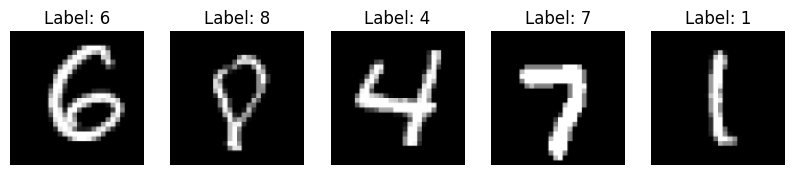

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def display_random_images(training_data, num_images=5):
    indices = np.random.choice(len(training_data), num_images, replace=False)

    plt.figure(figsize=(10, 10))

    for i, idx in enumerate(indices):
        image, label = training_data[idx]
        image = image.reshape(128, 128)

        label_index = np.argmax(label)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label_index}")
        plt.axis('off')

    plt.show()

display_random_images(training_data, num_images=5)

In [ ]:
network = Network([128*128, 30, 10])

In [ ]:
import time
start_time = time.time()

network.SGD(training_data, 10, 64, 3.0, test_data=test_data)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"SGD execution time: {elapsed_time:.2f} seconds")

Epoch 0: 1745 / 10000
Epoch 1: 4920 / 10000
Epoch 2: 6064 / 10000
Epoch 3: 7600 / 10000
Epoch 4: 8052 / 10000
Epoch 5: 7986 / 10000
Epoch 6: 8250 / 10000
Epoch 7: 8168 / 10000
Epoch 8: 8294 / 10000
Epoch 9: 8388 / 10000
SGD execution time: 1004.14 seconds


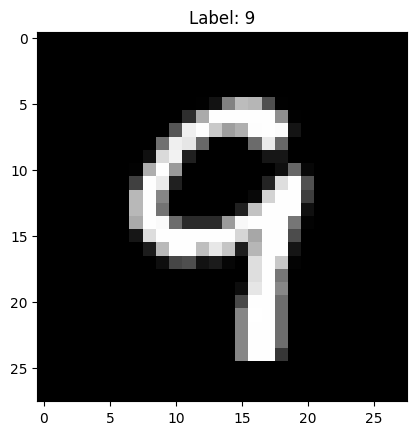

Prediction time: 0.00600
Predicted label: 9
True label: 9


In [ ]:
import time

def predict_single_image(network, test_data, index):
    x, true_label = test_data[index]

    start_time = time.time()
    output = network.feedforward(x)
    end_time = time.time()

    elapsed_time = end_time - start_time
    print(f"Prediction time: {elapsed_time:.5f}")

    predicted_label = np.argmax(output)

    return predicted_label, true_label


index = 150
image = test_data[index][0]
label = test_data[index][1]
image = image.reshape(28, 28)

plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

predicted_label, true_label = predict_single_image(network, test_data, index)

print(f"Predicted label: {predicted_label}")
print(f"True label: {true_label}")


## Model on GPU

In [ ]:
import numpy as np
import cupy as cp
from numba import cuda

In [ ]:
import pickle
import gzip
import numpy as np
import cupy as cp
import cv2

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data."""
    with gzip.open('./mnist.pkl.gz', 'rb') as f:
        # Specify the encoding as 'latin1' for compatibility with Python 2 pickles
        training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    return (training_data, validation_data, test_data)

def resize_image(image_array, size=(128, 128)):
    """Resize the image array to the specified size using OpenCV."""
    image = image_array.reshape(28, 28)  # Original MNIST image shape
    resized_image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
    resized_image = resized_image.astype(np.float32)  # Ensure it's in the correct format
    resized_image /= 255.0  # Normalize to [0, 1]
    return resized_image.reshape(size[0] * size[1], 1)

def load_data_wrapper(resize=True, size=(128, 128)):
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks on GPU."""
    tr_d, va_d, te_d = load_data()

    if resize:
        # Resize the images
        tr_d = ([resize_image(x, size) for x in tr_d[0]], tr_d[1])
        va_d = ([resize_image(x, size) for x in va_d[0]], va_d[1])
        te_d = ([resize_image(x, size) for x in te_d[0]], te_d[1])

    # Convert training data to CuPy arrays and reshape
    training_inputs = cp.asarray([cp.reshape(x, (size[0] * size[1], 1)) for x in tr_d[0]])
    training_results = cp.asarray([vectorized_result(y) for y in tr_d[1]])
    training_data = list(zip(training_inputs, training_results))

    # Convert validation and test data to CuPy arrays and reshape
    validation_inputs = cp.asarray([cp.reshape(x, (size[0] * size[1], 1)) for x in va_d[0]])
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = cp.asarray([cp.reshape(x, (size[0] * size[1], 1)) for x in te_d[0]])
    test_data = list(zip(test_inputs, te_d[1]))

    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = cp.zeros((10, 1))
    e[j] = 1.0
    return e

In [ ]:
import random
import cupy as cp

class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network. For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron. The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1. Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [cp.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [cp.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(cp.dot(w, a) + b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent. The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs. The other non-optional parameters are
        self-explanatory. If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out. This is useful for
        tracking progress, but slows things down substantially."""
        if test_data:
            n_test = len(test_data)

        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k + mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print("Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test))
            else:
                print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        mini_batch_size = len(mini_batch)
        x_batch = cp.column_stack([x for x, y in mini_batch])
        y_batch = cp.column_stack([y for x, y in mini_batch])

        nabla_b = [cp.zeros(b.shape) for b in self.biases]
        nabla_w = [cp.zeros(w.shape) for w in self.weights]

        delta_nabla_b, delta_nabla_w = self.backprop(x_batch, y_batch)
        nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

        self.weights = [w - (eta / mini_batch_size) * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta / mini_batch_size) * nb for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x_batch, y_batch):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x. ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [cp.zeros(b.shape) for b in self.biases]
        nabla_w = [cp.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x_batch
        activations = [x_batch]  # list to store all the activations, layer by layer
        zs = []  # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = cp.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y_batch) * sigmoid_prime(zs[-1])
        nabla_b[-1] = cp.sum(delta, axis=1, keepdims=True)
        nabla_w[-1] = cp.dot(delta, activations[-2].transpose())

        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = cp.dot(self.weights[-l + 1].transpose(), delta) * sp
            nabla_b[-l] = cp.sum(delta, axis=1, keepdims=True)
            nabla_w[-l] = cp.dot(delta, activations[-l - 1].transpose())

        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(cp.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations - y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0 / (1.0 + cp.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z) * (1 - sigmoid(z))

In [ ]:
network = Network([128*128, 30, 10])

In [ ]:
training_data, validation_data, test_data = load_data_wrapper()

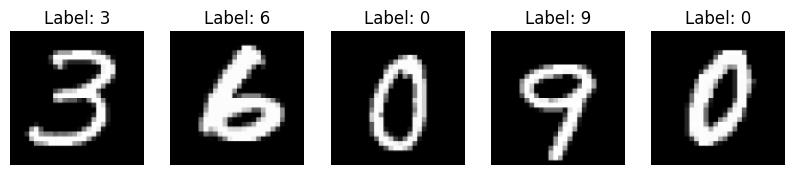

In [ ]:
import cupy as cp
import matplotlib.pyplot as plt

def display_random_images(training_data, num_images=5):
    indices = cp.random.choice(len(training_data), num_images, replace=False)

    plt.figure(figsize=(10, 10))

    for i, idx in enumerate(indices):
        image, label = training_data[int(idx)]
        image = cp.asnumpy(image).reshape((128, 128))

        label_index = cp.argmax(label)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {int(label_index)}")
        plt.axis('off')

    plt.show()

display_random_images(training_data, num_images=5)

In [ ]:
import time
start_time = time.time()

network.SGD(training_data, 10, 64, 3.0, test_data=test_data)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"SGD execution time on GPU: {elapsed_time:.2f} seconds")

Epoch 0: 2774 / 10000
Epoch 1: 3243 / 10000
Epoch 2: 6229 / 10000
Epoch 3: 6876 / 10000
Epoch 4: 7246 / 10000
Epoch 5: 7743 / 10000
Epoch 6: 8280 / 10000
Epoch 7: 8323 / 10000
Epoch 8: 8347 / 10000
Epoch 9: 8615 / 10000
SGD execution time on GPU: 66.99 seconds


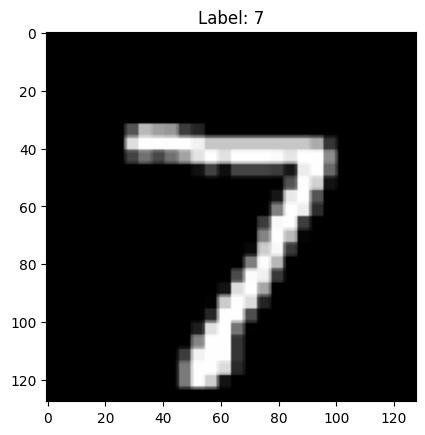

Prediction time: 0.00092
Predicted label: 7
True label: 7


In [ ]:
import time

def predict_single_image(network, test_data, index):
    x, true_label = test_data[index]
    x = cp.array(x)

    start_time = time.time()
    output = network.feedforward(x)
    end_time = time.time()

    elapsed_time = end_time - start_time
    print(f"Prediction time: {elapsed_time:.5f}")

    predicted_label = cp.argmax(output).get()

    return predicted_label, true_label


index = 0
image = cp.asnumpy(test_data[index][0])
label = test_data[index][1]
image = image.reshape(128, 128)

plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

predicted_label, true_label = predict_single_image(network, test_data, index)

print(f"Predicted label: {predicted_label}")
print(f"True label: {true_label}")


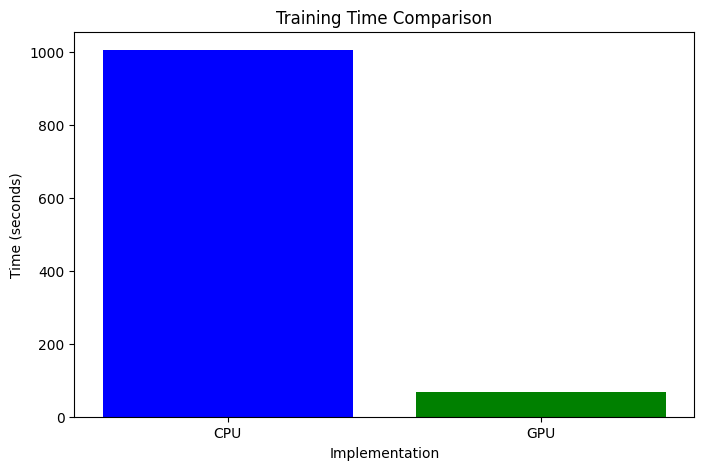

In [2]:
import matplotlib.pyplot as plt

cpu = 1004.14
gpu = 66.99

labels = ['CPU', 'GPU']
times = [cpu, gpu]

plt.figure(figsize=(8, 5))
plt.bar(labels, times, color=['blue', 'green'])
plt.title('Training Time Comparison')
plt.xlabel('Implementation')
plt.ylabel('Time (seconds)')
plt.show()